## Import libraries and python files

In [2]:
#import useful libraries 
import pandas as pd
import json
import sys
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
%matplotlib inline 

from data_loader import *
%load_ext autoreload
%autoreload 2


##link to the datasets
##https://www.cs.cmu.edu/~ark/personas/
##https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv
##https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset
##https://www.kaggle.com/datasets/unanimad/the-oscar-award/data

In [3]:
#no need to run this cell anymore
import requests
from bs4 import BeautifulSoup

#get the URL content
url = "https://en.wikipedia.org/wiki/List_of_Academy_Awards_ceremonies"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

#find all tables on the page
tables = soup.find_all('table', {'class': 'wikitable'})

#select the second table which is supposed to be the one with ceremonies
ceremonies_table = tables[1]  # This is assuming the second table is the correct one

#initialize a list for the ceremony numbers and dates
ceremony_numbers = []
ceremony_dates = []

#extract the ceremony numbers and dates
for row in ceremonies_table.find_all('tr')[1:]:  # Skip the header row
    cells = row.find_all('td')  # Get all data cells
    if len(cells) > 1:  # If there are at least two columns
        ceremony_numbers.append(cells[0].text.strip())  # Add the ceremony number
        ceremony_dates.append(cells[1].text.strip())  # Add the ceremony date

#create a DataFrame from the two lists
df_date_ceremony = pd.DataFrame({
    'ceremony': ceremony_numbers,
    'date': ceremony_dates
})


#convert 'Ceremony' to numeric by stripping off the 'st', 'nd', 'rd', 'th'
df_date_ceremony['ceremony'] = df_date_ceremony['ceremony'].str.extract('(\d+)').astype(int)

#convert 'Date' to datetime
df_date_ceremony['date'] = pd.to_datetime(df_date_ceremony['date'])

#format the date to YYYY-MM-DD
df_date_ceremony['date'] = df_date_ceremony['date'].dt.strftime('%Y-%m-%d')

#save the DataFrame to a CSV file
df_date_ceremony.to_csv('oscars_ceremony_dates.csv', index=False)


display(df_date_ceremony)

,ceremony,date
0,1,1929-05-16
1,2,1930-04-03
2,3,1930-11-05
3,4,1931-11-10
4,5,1932-11-18
...,...,...
91,92,2020-02-09
92,93,2021-04-25
93,94,2022-03-27
94,95,2023-03-12


## Load the different datasets

In [4]:
##load datasets from CMU dataset
df_character = load_character().copy()
df_movie = load_movie().copy()
df_name_cluster = load_name_cluster().copy()
df_summary = load_plot_summary().copy()
df_tropes_cluster = load_tropes_cluster().copy()

In [5]:
df_movie.head()

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>


In [6]:
df_movie.shape

(81741, 12)

In [7]:
# Replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

# Load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

# Display the loaded DataFrame
display(df_id_translation)

,tconst,Freebase ID
0,nm0010930,/m/0282x
1,nm0124133,/m/09b6zr
2,nm0684496,/m/014d3
3,nm0061667,/m/01rgr
4,tt1675434,/m/0hgqwpj
...,...,...
990440,tt20913312,None
990441,tt29623578,None
990442,nm1456284,None
990443,tt27348595,None


In [8]:
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
#df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)
print(df_id_translation.shape)

(397518, 2)


In [9]:
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)
print(df_id_translation.shape)

(396337, 2)


In [10]:
df_movie = pd.merge(df_movie, df_id_translation, on='Freebase ID', how='left')
display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726


In [11]:
#compute percentage of missing values for df_mvoei
percentage_missing_values_year = (df_movie['Year'].isna().sum()/len(df_movie['Year']))*100
print(f"The percentage of missing values 'Year' release date is {format(percentage_missing_values_year, '.3f')}%.")

percentage_missing_values_month = (df_movie['Month'].isna().sum()/len(df_movie['Month']))*100
print(f"The percentage of missing values 'Month' release date (and therefore 'Day') is {format(percentage_missing_values_month, '.3f')}%.")

percentage_missing_values_revenues = (df_movie['Box office'].isna().sum()/len(df_movie['Box office']))*100
print(f"The percentage of missing values 'Box office' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_runtime = (df_movie['Runtime'].isna().sum()/len(df_movie['Runtime']))*100
print(f"The percentage of missing values 'Runtime' is {format(percentage_missing_values_runtime, '.3f')}%.")

percentage_missing_values_tconst = (df_movie['tconst'].isna().sum()/len(df_movie['tconst']))*100
print(f"The percentage of missing values 'tconst' is {format(percentage_missing_values_tconst, '.3f')}%.")


The percentage of missing values 'Year' release date is 8.444%.
The percentage of missing values 'Month' release date (and therefore 'Day') is 51.832%.
The percentage of missing values 'Box office' is 89.722%.
The percentage of missing values 'Runtime' is 25.018%.
The percentage of missing values 'tconst' is 9.769%.


In [12]:
##As we can see, a lot of 'Box office' data is missing

## Load addtionnal datasets and merge what we need 

In [13]:
#load imdb dataset (from kaggle)
df_imdb_movie = load_movie_imdb_kaggle()
df_imdb_rating = load_rating_imdb_kaggle() 

In [14]:
#merge movies with rating 
df_movie_rating = pd.merge(df_imdb_movie, df_imdb_rating, on='tconst', how='inner')
display(df_movie_rating)

,tconst,titleType,Name,originalTitle,isAdult,Year,endYear,Runtime,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,Romance,5.3,207
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100.0,"Documentary,News,Sport",5.3,484
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,\N,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"Action,Adventure,Biography",6.0,854
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90.0,Drama,5.0,21
...,...,...,...,...,...,...,...,...,...,...,...
299375,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84.0,Thriller,5.8,1446
299376,tt9916362,movie,Coven,Akelarre,0,2020,\N,92.0,"Drama,History",6.4,5600
299377,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,NaN,"Adventure,History,War",3.5,17
299378,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123.0,Drama,8.6,7


In [15]:
#merge CMU dataset with IMDB dataset
df_movie = pd.merge(df_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333,4.9,56854.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320,6.1,2888.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949,6.0,621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259,6.8,3191.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411,5.8,110.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726,NaN,NaN


In [16]:
percentage_missing_values_rating = (df_movie['averageRating'].isna().sum()/len(df_movie['averageRating']))*100
print(f"The percentage of missing values 'averageRating' is {format(percentage_missing_values_rating, '.3f')}%.")

percentage_missing_values_votes = (df_movie['numVotes'].isna().sum()/len(df_movie['numVotes']))*100
print(f"The percentage of missing values 'numVotes' is {format(percentage_missing_values_votes, '.3f')}%.")

print(f"The number of movies with missing values for 'averageRating' and 'numVotes' is {df_movie['averageRating'].isna().sum()}.")

The percentage of missing values 'averageRating' is 31.271%.
The percentage of missing values 'numVotes' is 31.271%.
The number of movies with missing values for 'averageRating' and 'numVotes' is 25561.


In [17]:
## load kaggle movie metadata
df_kaggle_movie = load_movie_kaggle()
display(df_kaggle_movie)

,adult,belongs_to_collection,budget,genres,homepage,movieId,tconst,original_language,original_title,overview,...,spoken_languages,status,tagline,Name,video,vote_average,vote_count,Year,Month,Day
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,10,30
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,12,15
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,12,22
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,12,22
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,<NA>,<NA>,<NA>
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011,11,17
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,8,1
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917,10,21


In [18]:
#merge the datasets on the 'Name', 'Year' and 'tconst' columns
df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'tconst', 'Month', 'Day']], on=['Name', 'Year','tconst'], how='left', suffixes=('', '_df2'))

#use 'combine_first' to fill in the 'Box office' values from df_kaggle_movie where they are NaN in df_movie
df_movie['Month'] = df_movie['Month'].combine_first(df_movie['Month_df2'])
df_movie['Day'] = df_movie['Day'].combine_first(df_movie['Day_df2'])

#drop the extra 'Box office' column from df_kaggle_movie
df_movie.drop('Month_df2', axis=1, inplace=True)
df_movie.drop('Day_df2', axis=1, inplace=True)

df_movie = df_movie.drop_duplicates(subset='Wikipedia ID', keep='first')

display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333,4.9,56854.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320,6.1,2888.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949,6.0,621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81752,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585,NaN,NaN
81753,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259,6.8,3191.0
81754,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411,5.8,110.0
81755,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726,NaN,NaN


In [19]:
percentage_missing_values_year = (df_movie['Year'].isna().sum()/len(df_movie['Year']))*100
print(f"The percentage of missing values 'Year' release date is {format(percentage_missing_values_year, '.3f')}%.")

percentage_missing_values_month = (df_movie['Month'].isna().sum()/len(df_movie['Month']))*100
print(f"The percentage of missing values 'Month' release date (and therefore 'Day') is {format(percentage_missing_values_month, '.3f')}%.")

#as we can see, we decrease the percentage of missing values for 'Month' and 'Day' by merging the two datasets by almost 10%

The percentage of missing values 'Year' release date is 8.444%.
The percentage of missing values 'Month' release date (and therefore 'Day') is 42.899%.


In [20]:
#load oscar reward dataset
df_oscar = load_oscar_winner()
display(df_oscar)

,Year,year_ceremony,ceremony,category,name,Name,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10755,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True
10756,2022,2023,95,WRITING (Original Screenplay),Written by Steven Spielberg & Tony Kushner,The Fabelmans,False
10757,2022,2023,95,WRITING (Original Screenplay),Written by Todd Field,Tár,False
10758,2022,2023,95,WRITING (Original Screenplay),Written by Ruben Östlund,Triangle of Sadness,False


In [21]:
#load file with ceremony dates
df_date_ceremony = pd.read_csv('oscars_ceremony_dates.csv')

#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]

#merge the datasets on ceremony number
df_winner_movie = pd.merge(df_winner_movie, df_date_ceremony, on='ceremony', how='left')
display(df_winner_movie)

,Year,year_ceremony,ceremony,category,name,Name,winner,date
0,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True,1929-05-16
1,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True,1929-05-16
2,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True,1929-05-16
3,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True,1929-05-16
4,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,True,1929-05-16
...,...,...,...,...,...,...,...,...
2144,2022,2023,95,SOUND,"Mark Weingarten, James H. Mather, Al Nelson, C...",Top Gun: Maverick,True,2023-03-12
2145,2022,2023,95,VISUAL EFFECTS,"Joe Letteri, Richard Baneham, Eric Saindon and...",Avatar: The Way of Water,True,2023-03-12
2146,2022,2023,95,WRITING (Adapted Screenplay),Screenplay by Sarah Polley,Women Talking,True,2023-03-12
2147,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True,2023-03-12


In [22]:
#group by the movie name and count the winners time
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    date_won=pd.NamedAgg(column='date', aggfunc=lambda x: list(x))
).reset_index()

#sort the movies by oscars won
df_oscar_wins = df_winner_movie.sort_values(by='num_oscars_won', ascending=False)

display(df_oscar_wins)


,Name,num_oscars_won,date_won
1203,Titanic,12,"[1954-03-25, 1998-03-23, 1998-03-23, 1998-03-2..."
1261,West Side Story,11,"[1962-04-09, 1962-04-09, 1962-04-09, 1962-04-0..."
1045,The Lord of the Rings: The Return of the King,11,"[2004-02-29, 2004-02-29, 2004-02-29, 2004-02-2..."
130,Ben-Hur,11,"[1960-04-04, 1960-04-04, 1960-04-04, 1960-04-0..."
376,Gigi,9,"[1959-04-06, 1959-04-06, 1959-04-06, 1959-04-0..."
...,...,...,...
516,Kolya,1,[1997-03-24]
517,Kon-Tiki,1,[1952-03-20]
518,Krakatoa,1,[1934-03-16]
521,La Cucaracha,1,[1935-02-27]


In [23]:
#merge CUM and oscars awards dataset
df_movie = pd.merge(df_movie, df_oscar_wins, left_on='Name', right_on='Name', how='left')

#replace NaN values in 'num_oscars_won' with 0 for movies that didn't win any Oscars
df_movie['num_oscars_won'].fillna(0, inplace=True)

display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst,averageRating,numVotes,num_oscars_won,date_won
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333,4.9,56854.0,0.0,NaN
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916,NaN,NaN,0.0,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806,5.6,40.0,0.0,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320,6.1,2888.0,0.0,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949,6.0,621.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585,NaN,NaN,0.0,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259,6.8,3191.0,0.0,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411,5.8,110.0,0.0,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726,NaN,NaN,0.0,NaN


In [24]:
percentage_oascar_movies = ((df_movie['num_oscars_won']!=0).sum()/len(df_movie['num_oscars_won']))*100
print(f"The percentage of movies having won an oscar is {format(percentage_oascar_movies, '.3f')}%.")

The percentage of movies having won an oscar is 1.895%.


## Research on release month and revenues 

In [25]:
import matplotlib.pyplot as plt

### Clean the data
1. Drop 'nan' row for box office and Month columns.
2. Drop the row with 'Year' smaller than 1800.


In [26]:
#1. drop 'nan' row of box office and month release columns.
df_movie.dropna(subset = ['Box office', 'Month'], inplace = True)

#2. Drop the row with 'Year' smaller than 1800.
df_movie = df_movie[df_movie['Year'] >= 1800]

### Can we find any trends in movie release dates within a year?
Y: box office
X: dummies variable of months
1. regress X on Y
2. regress X on Y with respect to differen country.

In [27]:
#0. use w as a dictionary to store the coefficient.
w = {}

#1. regress X on Y
movie_revenues = df_movie['Box office'].values
month_release = pd.get_dummies(df_movie['Month']).values
#remove one month column to select it as a baseline here December
month_release = month_release[:, :-1].astype(int)
month_release = sm.add_constant(month_release)
model = sm.OLS(movie_revenues, month_release).fit()
w['ALL'] = model.params

### Got the list of countries

In [28]:
#The following step is to find the list of all the countries name which is show in the 'Countries (Freebase ID:name tuples)' column
# Define a function to extract country names
def extract_countries(location):
    # Convert the string to a dictionary
    location_dict = json.loads(location.replace("'", "\""))
    # Extract and return the country names
    return list(location_dict.values())
#transfer the text of 'Countries (Freebase ID:name tuples)' into some string only contain the countries name
df_aux = df_movie['Countries (Freebase ID:name tuples)'].apply(extract_countries)
df_aux = pd.DataFrame(df_aux.apply(lambda x: ', '.join(x) if x else None))
df_aux = df_aux.dropna()
#list the unique countries name.
list_of_countries = df_aux['Countries (Freebase ID:name tuples)'].unique()
string_of_countries = ','.join(list_of_countries)
list_of_countries = string_of_countries.split(',')
list_of_countries = [x.strip() for x in list_of_countries]
list_of_countries = list(set(list_of_countries))
#drop the name with direction (e.g west, south, east)
direction = ['South','North','West','East']
direction_2 = [ x.lower() for x in direction]
di = direction + direction_2
display(di)
for i in list_of_countries:
    if any(substring in i for substring in di):
        print(i)
#delete south korea and west germany
list_of_countries.remove('South Korea')
list_of_countries.remove('West Germany')

['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']

West Germany
South Korea
South Africa


### Regression for each countries

In [29]:
#we only research on the countries with data more than 200.
for country in list_of_countries:
    index_of_data = df_movie['Countries (Freebase ID:name tuples)'].str.contains(country)
    if index_of_data.sum() >= 200:
        model = sm.OLS(df_movie[index_of_data]['Box office'].values, month_release[index_of_data,:]).fit()
        w[country] = model.params

### Visualize all the results

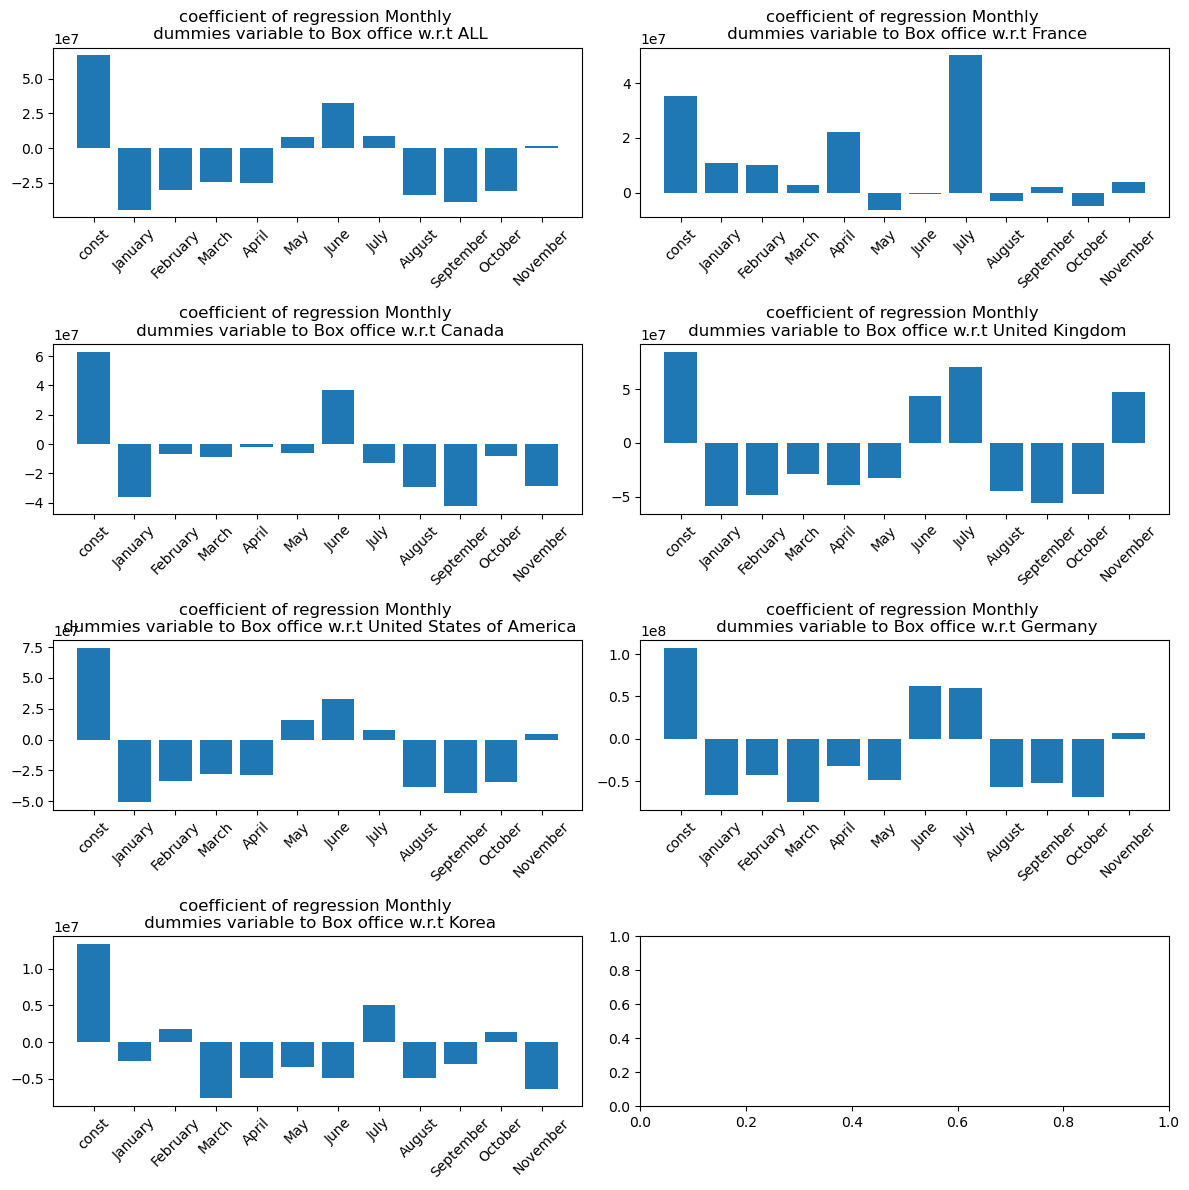

In [30]:
import calendar
# Generate a list of month names
months = list(calendar.month_name)[1:]
months = months[:-1]
months.insert(0, 'const')

# Create a subplot with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()

# Create bar charts for each country
for i, name in zip(np.arange(0,8),w.keys()):
    ax = axes[i]
    ax.bar(months, w[name])
    ax.set_title('coefficient of regression Monthly \n dummies variable to Box office w.r.t {}'.format(name))
    ax.set_xticks(range(len(months)))
    ax.set_xticklabels(months, rotation=45) 

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### What we find?
Note: in monthly research we did not research the countries with data less than 200，because it will lead to the lack of accuracy due to insufficient samples.

For overall data and each of the countries, it is obviously that if the movie was release on July it would be have higher Box Office than that of the other month. From January to May and from August to October, almost all the countries have lower Box Officer than the bench mark (i.e. December's Box Office). It is worth noting that the average Box offcier on July is way more higher than the other months in France. 

### Research on month release day over the historical


In [31]:
np.sort(df_movie['Year'].unique())

array([1897, 1914, 1915, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype=object)

In [32]:
#get the time interval
year_list = 1900 + np.arange(0,121,20)
year_list[0] = df_movie['Year'].min()

#0. use w as a dictionary to store the coefficient.
w_over_twenty_year = {}

#1. regress X on Y over the time interval
for i in np.arange(0,len(year_list)-1):
    df = df_movie [ (df_movie["Year"] >= year_list[i]).values and (df_movie["Year"] < year_list[i+1]).values]
    movie_revenues = df['Box office'].values
    month_release = pd.get_dummies(df['Month']).values
    #remove one month column to select it as a baseline here December
    month_release = month_release[:, :-1].astype(int)
    month_release = sm.add_constant(month_release)
    model = sm.OLS(movie_revenues, month_release).fit()
    w_over_twenty_year[year_list[i]] = model.params

store_name = []
for name in w_over_twenty_year.keys():
   if len(w_over_twenty_year[name]) < 12:
       store_name.append(name)

for name in store_name:
    del w_over_twenty_year[name]


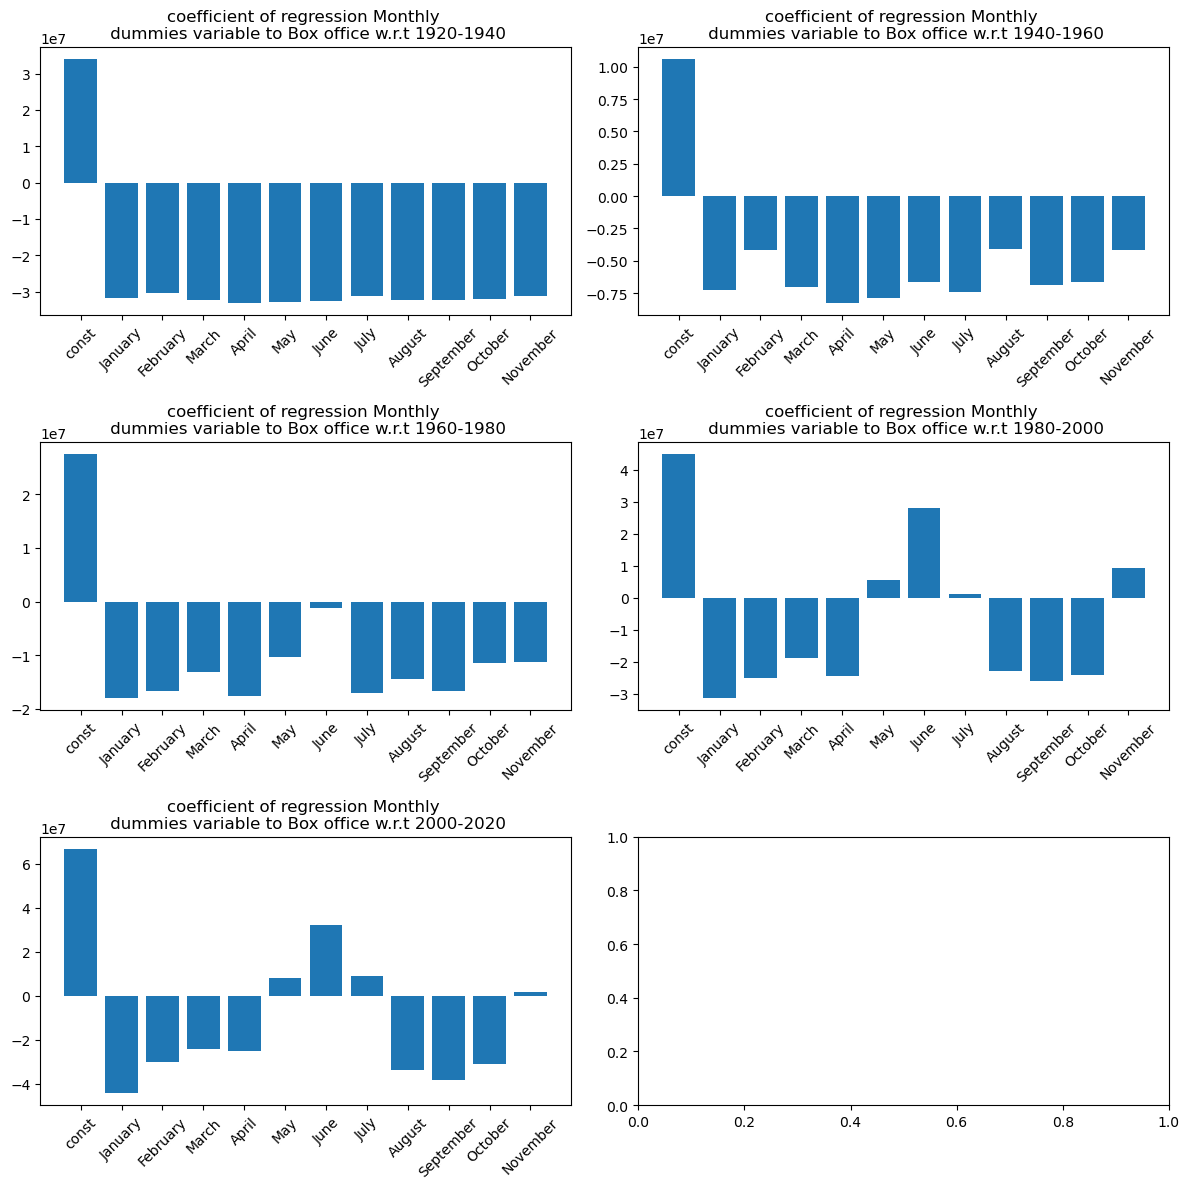

In [33]:
import calendar
# Generate a list of month names
months = list(calendar.month_name)[1:]
months = months[:-1]
months.insert(0, 'const')

# Create a subplot with 4 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Create bar charts for each country
for i, name in zip(np.arange(0,8),w_over_twenty_year.keys()):
    ax = axes[i]
    ax.bar(months, w_over_twenty_year[name])
    ax.set_title('coefficient of regression Monthly \n dummies variable to Box office w.r.t {}-{}'.format(name, name+20))
    ax.set_xticks(range(len(months)))
    ax.set_xticklabels(months, rotation=45) 

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

We find something weird that if we release the movies on December it would be higher than the other months with rolling window of 20 years from 1920 to 1980 on average. It could be a interest topic. hello